In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image
import os
import time
import copy

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms, utils
import torch.optim as optim
import sklearn
import sklearn.model_selection as skl
import seaborn as sn
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
use_gpu = torch.cuda.is_available

if use_gpu:
  print('GPU available')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

device = torch.device("cuda:0" if use_gpu else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
print("Torch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)
!python --version

GPU available
cuda:0
Torch version:  2.6.0.dev20241220+cu126
Torchvision version:  0.22.0.dev20241220+cu126
Python 3.12.6


In [26]:
# Directorio de la carpeta donde esta el dataset
img_folder = 'C:\\Users\\yleob\\OneDrive - Instituto Politecnico Nacional\\Documents\\1. Leo\\ESCOM\\Semestre 6\\Redes Nuronales\\Proyecto\\Proyecto-Redes\clasifica-el-sargazo-24-b\images_public'
csv_file = 'C:\\Users\\yleob\\OneDrive - Instituto Politecnico Nacional\\Documents\\1. Leo\\ESCOM\\Semestre 6\\Redes Nuronales\\Proyecto\\Proyecto-Redes\\clasifica-el-sargazo-24-b\\train_data.csv'
test_file = 'C:\\Users\\yleob\\OneDrive - Instituto Politecnico Nacional\\Documents\\1. Leo\\ESCOM\\Semestre 6\\Redes Nuronales\\Proyecto\\Proyecto-Redes\\clasifica-el-sargazo-24-b\\test_data.csv'

# Hyper parameters
epochs = 50
current_epoch = 0
batch_size = 64
learning_rate = 0.001
run_training = True #Si deseamos que el notebook ejecute el entrenamiento
model_name = 'efficientnet_b7' # Red a cargar
pretrained = True # True indica que la red se va a inicializar con los parámetros entrenados
feature_extract = True #True indica que no se actualizan los parámetros
save_weights = True
last_iteration_before_running_out = 154


wts_str = 'w_' + model_name + '_pret_' + str(pretrained) + '_feat_' + str(feature_extract) + '_lr_'+ str(learning_rate)
print(wts_str)
saved_file = 'C:\\Users\\yleob\\OneDrive - Instituto Politecnico Nacional\\Documents\\1. Leo\\ESCOM\\Semestre 6\\Redes Nuronales\\Proyecto\\Proyecto-Redes' + wts_str + '_best.pt'

w_efficientnet_b7_pret_True_feat_True_lr_0.001


<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\yleob\AppData\Local\Temp\ipykernel_88144\2454296568.py:2: SyntaxWarning: invalid escape sequence '\c'
  img_folder = 'C:\\Users\\yleob\\OneDrive - Instituto Politecnico Nacional\\Documents\\1. Leo\\ESCOM\\Semestre 6\\Redes Nuronales\\Proyecto\\Proyecto-Redes\clasifica-el-sargazo-24-b\images_public'


## Objeto dataset

En PyTorch, un objeto Dataset se encarga de almacenar y manejar los datos que se usarán en modelos de aprendizaje automático. Es una clase abstracta de la cual se derivan clases específicas para manejar diferentes tipos de datos.  En este caso el objeto se implementa para leer de cada imagen su correspondiente etiqueta.

In [27]:
class SargazoDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        """
        Args:
            txt_frame_file (string): Path to the txt files with labels.
            images_path (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.sargazo_frame = dataframe
        self.root_dir = images_path
        self.transform = transform
        self.class2id = test_count = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}

    def pil_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __len__(self):
        return len(self.sargazo_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # cuidado si cambia la tabla se debe de cambiar esto
        image_path = os.path.join(self.root_dir, self.sargazo_frame.iloc[idx, 0])

        image = self.pil_loader(image_path)

        try:
            label = self.sargazo_frame.iloc[idx, 1]
        except:
            label = 'unknown'

        if self.transform is not None:
            image = self.transform(image)

        sample = (image, self.class2id[label])

        return sample

## Dividir conjunto de datos

In [28]:
class2id = test_count = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
id2class = {0: 'nada', 1: 'bajo', 2: 'moderado', 3: 'abundante', 4: 'excesivo'}
num_classes = len(id2class)

full_dataset = pd.read_csv(csv_file)
full_dataset.sample(5)

,Id,Category
1508,r515.jpg,bajo
1325,k0121.jpg,nada
588,k0952.jpg,nada
492,j0012.jpg,nada
1742,k0013.jpg,bajo


In [29]:
col_labels = 'Category'
random = 46 # for reproducible experiments

X = full_dataset.drop(columns=[col_labels])
y = full_dataset[col_labels]

# Aplicar sobremuestreo
ros = RandomOverSampler(random_state=random)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combinar características y etiquetas resampleadas en un nuevo DataFrame
balanced_dataset = pd.concat([X_resampled, y_resampled], axis=1)

# Aqui se divide el conjunto de datos
train_df, valid_df = skl.train_test_split(balanced_dataset, test_size = 0.2, stratify = balanced_dataset[col_labels], random_state = random)

training_dataset = SargazoDataset(train_df, img_folder)
test_dataset = SargazoDataset(valid_df, img_folder)

print("Número de ejemplos:", len(training_dataset))

def show_image(image, label):
    plt.imshow(image, cmap = 'gray')
    plt.pause(0.001)  # pause a bit so that plots are updated

Número de ejemplos: 4668


## Mostrar unos ejemplos

(<PIL.Image.Image image mode=RGB size=899x1599 at 0x2FAA61FBF20>, 4)


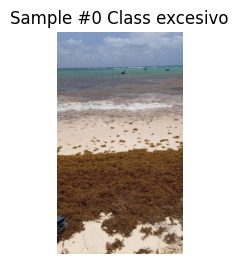

(<PIL.Image.Image image mode=RGB size=960x960 at 0x2FAAB060110>, 1)


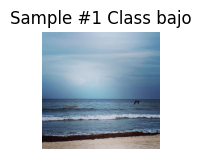

(<PIL.Image.Image image mode=RGB size=960x639 at 0x2FAA62001A0>, 2)


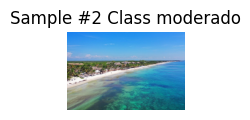

(<PIL.Image.Image image mode=RGB size=960x720 at 0x2FAA61FB590>, 4)


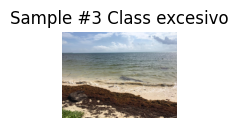

In [30]:
fig = plt.figure()

for i in range(len(training_dataset)):
    sample = training_dataset[i]
    print(sample)
    image, label = sample

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{} Class {}'.format(i, id2class[label]))
    ax.axis('off')
    show_image(image, label)

    if i == 3:
        plt.show()
        break

## Descenso por gradiente

Implementación del descenso por gradiente.

In [31]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception= False, save_after = 100):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #print(device)

    for epoch in range(current_epoch,num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))

        #Each epoch as a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in iter(dataloaders[phase]):
                #print(inputs)
                #print(labels)
                inputs = inputs.to(device)
                labels = labels.to(device)

                #zero the parameter gradients
                optimizer.zero_grad()

                #forward
                # track history
                with torch.set_grad_enabled(phase == 'train'):

                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2

                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss /len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), saved_file)
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

            if phase == 'train' and epoch % save_after == 0 :
                torch.save(model.state_dict(), wts_str + '_epoch' + str(epoch) + '.pt')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    #load the best model
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, val_loss_history, train_loss_history

In [32]:
# set model parameters
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            # Freeze parameters
            param.requires_grad = False

## Crear modelo de red neuronal

In [33]:
%pip install timm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [34]:
import torch.nn as nn
import timm

# Initialize and reshape the networks
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == "efficientnet_b0":
        model_ft = models.efficientnet_b0(pretrained=use_pretrained)
        if feature_extract:
            for param in model_ft.parameters():
                param.requires_grad = False
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    if model_name == "efficientnet_b7":
        model_ft = models.efficientnet_b3(pretrained=use_pretrained)
        if feature_extract:
            for param in model_ft.parameters():
                param.requires_grad = False
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "EfficientNetV2":
        model_ft = timm.create_model('efficientnetv2_rw_s', pretrained=use_pretrained)
        if feature_extract:
            for param in model_ft.parameters():
                param.requires_grad = False
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "DenseNet":
        model_ft = models.densenet121(pretrained=use_pretrained)
        if feature_extract:
            for param in model_ft.parameters():
                param.requires_grad = False
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "vit_base_patch16_224":
        model_ft = timm.create_model('vit_base_patch16_224', pretrained=use_pretrained)
        if feature_extract:
            for param in model_ft.parameters():
                param.requires_grad = False
        num_ftrs = model_ft.head.in_features
        model_ft.head = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "BEiT":
        model_ft = timm.create_model('beit_base_patch16_224', pretrained=use_pretrained)
        if feature_extract:
            for param in model_ft.parameters():
                param.requires_grad = False
        num_ftrs = model_ft.head.in_features
        model_ft.head = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        raise ValueError("Modelo no implementado")
    return model_ft, input_size


# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=pretrained)

# Print the model we just instantiated
#print(model_ft)

model_ft.to(device)

C:\Users\yleob\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yleob\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

## Entrenamiento

In [35]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [36]:
# configure paths to the description txt file and the images folder
#images_path = '../input/sargazo-dataset/sargazo_dataset/images'

# Create training and validation datasets

if run_training:
  image_datasets = {'train': SargazoDataset(train_df, img_folder, data_transforms['train']), 'val': SargazoDataset(valid_df, img_folder, data_transforms['val'])}
  dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}
else:
  image_datasets = {'val': SargazoDataset(valid_df, img_folder, data_transforms['val'])}
  dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['val']}

In [37]:
# create the optimizer
params_to_update = model_ft.parameters()
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
else:
    params_to_update = [param for param in model_ft.parameters() if param.requires_grad]

optimizer_ft = optim.Adam(params_to_update, lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [38]:
# model_ft.load_state_dict(torch.load('w_vgg_pret_True_feat_False_lr_0.001_best.pt'))

In [ ]:
model_ft = model_ft.to(device)
# if run_training:
#     if last_iteration_before_running_out != 0:
#         model_ft.load_state_dict(torch.load(wts_str + '_best.pt'))
#         current_epoch = last_iteration_before_running_out
#     model_ft, hist, hist_t, loss_hist, loss_hist_t = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=epochs)
# else:
#     model_ft.load_state_dict(torch.load(saved_file))

if run_training:
    # Verificar si el archivo de pesos existe
    if os.path.exists(wts_str + '_best.pt'):
        print(f"Cargando pesos desde el archivo {wts_str + '_best.pt'}...")
        model_ft.load_state_dict(torch.load(wts_str + '_best.pt'))
        current_epoch = last_iteration_before_running_out
    else:
        print(f"No se encontró el archivo {wts_str + '_best.pt'}. Entrenando el modelo desde cero...")
        current_epoch = 0

    # Iniciar el entrenamiento
    model_ft, hist, hist_t, loss_hist, loss_hist_t = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=epochs)
else:
    # Intentar cargar los pesos para inferencia
    try:
        print(f"Cargando pesos para inferencia desde {saved_file}...")
        model_ft.load_state_dict(torch.load(saved_file))
    except FileNotFoundError:
        print(f"Error: El archivo {saved_file} no existe. Asegúrate de entrenar el modelo primero.")


No se encontró el archivo w_efficientnet_b7_pret_True_feat_True_lr_0.001_best.pt. Entrenando el modelo desde cero...
Epoch 0/49
train Loss: 1.5422 Acc: 0.3121
val Loss: 1.4466 Acc: 0.3745

Epoch 1/49


In [27]:
if save_weights:
    torch.save(model_ft.state_dict(), wts_str)

## Graficar resultados

In [28]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
if run_training:
  thist = []

  vhist = [h.cpu().numpy() for h in hist]
  thist = [h.cpu().numpy() for h in hist_t]
  #shist = [h.cpu().numpy() for h in scratch_hist]

  np.save('val_history', vhist)
  np.save('train_history', vhist)

  plt.title("Validation Accuracy vs. Number of Training Epochs")
  plt.xlabel("Training Epochs")
  plt.ylabel("Accuracy")
  plt.plot(range(1,epochs+1),thist,label="Training")
  plt.plot(range(1,epochs+1),vhist,label="Validation")
  plt.ylim((0,1.))
  plt.xticks(np.arange(1, epochs+1, 1.0))
  plt.legend()
  file_name = wts_str + '_acc.png'
  plt.savefig(file_name)
  plt.show()

NameError: name 'hist' is not defined

In [ ]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
if run_training:
  vhist_loss = np.array(loss_hist)
  thist_loss = np.array(loss_hist_t)

  np.save('val_history', vhist_loss)
  np.save('train_history', thist_loss)

  plt.title("Validation Loss vs. Number of Training Epochs")
  plt.xlabel("Training Epochs")
  plt.ylabel("Loss")
  plt.plot(range(1,epochs+1),thist_loss,label="Training")
  plt.plot(range(1,epochs+1),vhist_loss,label="Validation")
  plt.ylim((0,4.))
  plt.xticks(np.arange(1, epochs+1, 1.0))
  plt.legend()
  file_name = wts_str + '_loss.png'
  plt.savefig(file_name)
  plt.show()

In [ ]:
def test_model(model, dataloaders):
    print("Evaluating model")
    print(time.time())

    # Iterate over data
    it = 0
    for inputs, labels in dataloaders['val']:
        with torch.no_grad():
          inputs = inputs.to(device)
          labels = labels.to(device)

          model.train(False)
          model.eval()

          outputs = model(inputs)

          _, preds = torch.max(outputs, 1)

          np_pred_labels = preds.cpu().numpy()
          np_real_labels = labels.cpu().numpy()
          if it == 0:
              pred_labels = np_pred_labels
              real_labels = np_real_labels
          else:
              pred_labels = np.concatenate((pred_labels,np_pred_labels))
              real_labels = np.concatenate((real_labels,np_real_labels))
          it= it+1

          inputs = inputs.cpu()
          labels = labels.cpu()
          outputs = outputs.cpu()
          preds = preds.cpu()

          # Delete variables
          del inputs
          del labels
          del outputs
          del preds
          torch.cuda.empty_cache()

    print(time.time())
    return pred_labels,real_labels

In [ ]:
predict_labels,actual_labels = test_model(model_ft, dataloaders_dict)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual_labels,predict_labels))

In [ ]:
df_confusion = pd.crosstab(actual_labels, predict_labels,rownames=["True label"],colnames=["Predicted label"])
print(df_confusion)
df_confusion.rename(columns=id2class,index=id2class,inplace=True)
print(df_confusion)
df_confusion.to_csv('cm_exp5.csv')

In [ ]:
f, ax = plt.subplots(figsize=(9,6))

parameters = {'axes.labelsize': 10}
plt.rcParams.update(parameters)

g = sn.heatmap(df_confusion, annot = True, cmap = 'Blues',ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right')

plt.savefig("CM_exp5.eps",format = "eps",bbox_inches='tight')
plt.show()

In [ ]:
df_norm_col= round(df_confusion.div(df_confusion.sum(axis=1),axis=0),2)
print(df_norm_col)

In [ ]:
f, ax = plt.subplots(figsize=(9,6))

parameters = {'axes.labelsize': 10}
plt.rcParams.update(parameters)

g = sn.heatmap(df_norm_col, annot = True, cmap = 'Blues')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right')

plt.savefig("CM_exp5_norm.eps",format = "eps",bbox_inches='tight')
plt.show()

## Inferencia para el challenge

In [ ]:
test_df = pd.read_csv(test_file)
test_df.sample(5)


In [ ]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


model_ft.eval()
test_predictions = []
for file in test_df['image_name']:

    # cuidado si cambia la tabla se debe de cambiar esto
    image_path = os.path.join(img_folder, file)
    #print(image_path)

    image = pil_loader(image_path)
    img_transf = data_transforms['val'](image)
    img_transf = img_transf.unsqueeze(0)
    #print(img_transf.shape)

    #print(labels)
    img_transf = img_transf.to(device)

    outputs = model_ft(img_transf)
    #print(outputs)
    _, preds = torch.max(outputs, 1)
    test_predictions.append(id2class[preds.cpu().numpy()[0]])

#print(test_predictions)
temp = {'image_name': test_df['image_name'], 'label': test_predictions}
output_df = pd.DataFrame(data=temp)
output_df.sample(10)

output_df.to_csv('/content/drive/MyDrive/Prácticas Rede/Experimento 10/' + 'outputs.csv')